In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from bartpy.bartpy.sklearnmodel import SklearnModel
from tqdm import tqdm

from scipy.special import logit, expit
from scipy.stats import bernoulli

In [2]:
def TRV(y, W, p):
    return y*(W-p)/(p*(1-p))



In [3]:
# Experiment constants
N_replications = 20

In [4]:
#Case A dataset from https://arxiv.org/pdf/1812.07153.pdf
n=250

# data
X_1_15  = np.random.normal(loc=0, scale=1, size=(250,15))
X_16_30 = np.random.uniform(low=0,high=1, size=(250,15))
p_k = expit(X_1_15[:,:5] - X_16_30[:,:5])
X_31_35 = np.random.binomial(n=1, p=p_k)
X_36_40 = 5 + 0.75 * X_1_15[:,:5] * (X_16_30[:,:5] - X_31_35)
X=np.concatenate([X_1_15, X_16_30, X_31_35, X_36_40], axis=1)

# propensity scores
pi = expit(
    .3*np.sum(X_1_15[:,:5], axis=1) - 
    .5*np.sum(X_16_30[:,5:10], axis=1) - 
    .0001 * (np.sum(X_16_30[:,-5:], axis=1) + np.sum(X_31_35, axis=1)) +
    .055 * np.sum(X_36_40, axis=1)
)
Xp=np.concatenate(
    [
        X_1_15, 
        X_16_30, 
        X_31_35, 
        X_36_40, 
        np.reshape(pi, (len(pi),1))
    ], 
    axis=1
)

W = np.random.binomial(n=1, p=pi)

# potential outcomes
error = np.random.normal(0, np.sqrt(0.0001), size=n)

term = (
    X_16_30[:,0] * np.exp(np.reshape(X_16_30[:,-1:], n)) + 
    X_16_30[:,1] * np.exp(np.reshape(X_31_35[:,0], n)) + 
    X_16_30[:,2] * np.exp(np.reshape(X_31_35[:,1], n)) + 
    X_16_30[:,3] * np.exp(np.reshape(X_31_35[:,2], n)) 
)
f_of_X = term/(1+term)

Y0 = 0.15 * np.sum(X_1_15[:,:5], axis=1) + 1.5 * np.exp( 1 + f_of_X ) + error
Y1 = (
    np.sum(
        2.15*X_1_15[:,:5] + 
        2.75*X_1_15[:,:5]*X_1_15[:,:5] + 
        10 * X_1_15[:,:5]*X_1_15[:,:5]*X_1_15[:,:5],
        axis=1
    ) + 
    1.25*np.sqrt(.5 + 1.5*np.sum(X_36_40, axis=1)) + 
    error
)

tau = Y1-Y0

Y = W*Y1 + (1-W)*Y0
      
Y_i_star = TRV(Y,W,pi)

In [5]:
Y_i_star.shape

(250,)

In [6]:
kwargs = {
    "model": "causal_gaussian_mixture"
}
# create the multiple instantiations of model objects
model = []
model_with_p = []
for i in range(N_replications):
    model.append(
        SklearnModel(
            n_samples=2000, 
            n_burn=2000, 
            n_trees=200, 
            k=.1,
            thin=.2,#.2,
            n_chains=4,
            n_jobs=-1,
            store_in_sample_predictions=True,
            **kwargs
        )
    )
    model_with_p.append(
        SklearnModel(
            n_samples=2000, 
            n_burn=2000, 
            n_trees=200,
            k=.1,
            thin=.2,
            n_chains=4,
            n_jobs=-1,
            store_in_sample_predictions=True,
            **kwargs
        )
    )

Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture usin

In [7]:
for i in tqdm(range(N_replications)):
    model[i].fit_CGM(X, Y_i_star, W, pi)
    model_with_p[i].fit_CGM(Xp, Y_i_star, W, pi)

100%|██████████| 20/20 [7:50:48<00:00, 1412.42s/it]  


In [8]:
pred_CATE=np.zeros((n, N_replications))
pred_CATE_p=np.zeros((n, N_replications))
pred_response=np.zeros((n, N_replications))
pred_response_p=np.zeros((n, N_replications))

for i in tqdm(range(N_replications)):
    pred_CATE[:,i] = model[i].predict_CATE(X)
    pred_response[:,i] = model[i].predict_response(X)
    pred_CATE_p[:,i] = model_with_p[i].predict_CATE(Xp)
    pred_response_p[:,i] = model_with_p[i].predict_response(Xp)

100%|██████████| 20/20 [1:14:40<00:00, 224.05s/it]


MSE: 4325.146721357065
Bias: 0.1644843884310771


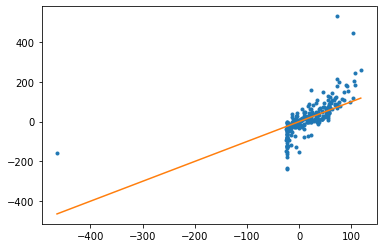

In [9]:
mean_pred_CATE_p = np.mean(pred_CATE_p, axis=1)
base = list(
    range(
        np.min(mean_pred_CATE_p).astype(int),
        np.max(mean_pred_CATE_p).astype(int)
    )
)
plt.plot(mean_pred_CATE_p, Y1-Y0, '.')
plt.plot(base, base)

print("MSE:", np.mean((mean_pred_CATE_p-tau)**2)) # trying to beat 4191.665
print("Bias:", np.mean(mean_pred_CATE_p-tau))


MSE: 5128.373341695178
Bias: 5.8510502177745725


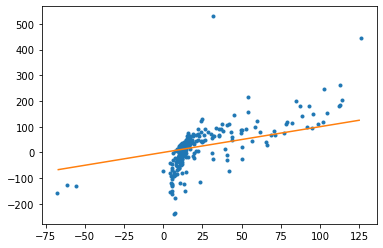

In [10]:
mean_pred_CATE = np.mean(pred_CATE, axis=1)
base = list(
    range(
        np.min(mean_pred_CATE).astype(int),
        np.max(mean_pred_CATE).astype(int)
    )
)
plt.plot(mean_pred_CATE, Y1-Y0, '.')
plt.plot(base, base)

print("MSE:", np.mean((mean_pred_CATE-tau)**2))  # trying to beat 4191.665
print("Bias:", np.mean(mean_pred_CATE-tau))


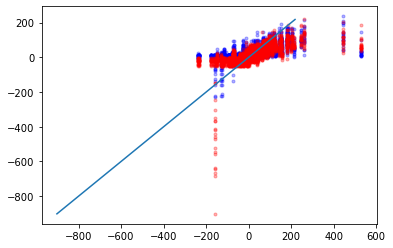

5094.1385530442585
4325.1196662430275


In [11]:
# Difference in predicted vs actual
plt.plot( tau, pred_CATE, '.', color='blue', alpha=.3)
plt.plot( tau, pred_CATE_p, '.', color='red', alpha=.3)
base = list(
    range(
        np.min(pred_CATE_p).astype(int),
        np.max(pred_CATE_p).astype(int)
    )
)
plt.plot(base, base)
plt.show()
print(np.var(tau - np.mean(pred_CATE, axis=1)))
print(np.var(tau - np.mean(pred_CATE_p, axis=1)))


In [ ]:
#Coverage

for i in tqdm(range(N_replications)):
    if (i==0):
        coverage_matrix=model[i].get_posterior_CATE()
    else:
        coverage_matrix=np.concatenate([coverage_matrix, model[i].get_posterior_CATE()], axis=0)

In [37]:
for i in tqdm(range(N_replications)):
    if (i==0):
        coverage_matrix_with_p=model_with_p[i].get_posterior_CATE()
    else:
        coverage_matrix_with_p=np.concatenate(
            [coverage_matrix_with_p, model_with_p[i].get_posterior_CATE()], 
            axis=0
        )    
        

100%|██████████| 20/20 [00:00<00:00, 34.43it/s]


In [38]:
q975 = np.quantile( coverage_matrix, q=0.975, axis=0)
q025 = np.quantile( coverage_matrix, q=0.025, axis=0)
U=np.array(tau<q975).astype(int)
L= np.array(q025<tau).astype(int)

q975_p = np.quantile( coverage_matrix_with_p, q=0.975, axis=0)
q025_p = np.quantile( coverage_matrix_with_p, q=0.025, axis=0)
U_p=np.array(tau<q975_p).astype(int)
L_p= np.array(q025_p<tau).astype(int)
print("Covereage without propensity score:", sum(U*L)/n)
print("Covereage with propensity score:   ", sum(U_p*L_p)/n)


Covereage without propensity score: 0.664
Covereage with propensity score:    0.796


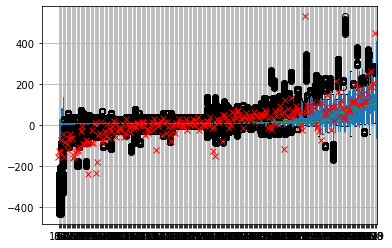

In [14]:
coverage_matrix=pd.DataFrame(coverage_matrix)
index_values=coverage_matrix.mean(axis=0).sort_values().index
temp2 = coverage_matrix.reindex(index_values, axis=1)
_=temp2.boxplot()
_=plt.plot(tau[index_values],'x', color='red')


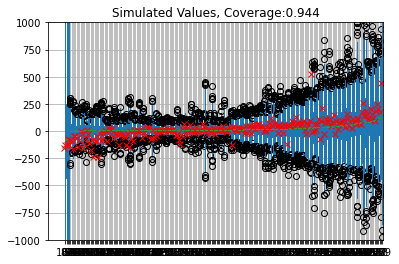

In [36]:
means = np.mean(coverage_matrix, axis=0)
stds = np.std(coverage_matrix, axis=0)*3.6

normal_simulation = pd.DataFrame(np.random.normal(loc=means, scale=stds, size=(1000,n)))
q975 = np.quantile( normal_simulation, q=0.975, axis=0)
q025 = np.quantile( normal_simulation, q=0.025, axis=0)
U=np.array(tau<q975).astype(int)
L= np.array(q025<tau).astype(int)
sum(U*L)/n

coverage_matrix=pd.DataFrame(coverage_matrix)
index_values=normal_simulation.mean(axis=0).sort_values().index
temp3 = normal_simulation.reindex(index_values, axis=1)
_=temp3.boxplot()
_=plt.plot(tau[index_values],'x', color='red')
plt.title("Simulated Values, Coverage:" + str(sum(U*L)/n))
_=plt.ylim((-1000,1000))

In [ ]:
#   Model Type Mean                       Square Error      Bias    95% CI Coverage
# 1 Gaussian-Process Mixture                  4191.665    13.207              0.780
# 2 Bayesian Additive Regression Tree         5856.135    -5.351              0.596
# 3 Transformed Outcome Tree                  7769.077    14.374              0.876
# 4 Fit Based Tree                            6154.396    15.633              0.928
# 5 Causal Tree                               8390.039    21.923              0.964
# 6 Transformed Outcome Random Forest         4993.576    0.317               0.932

# 7 BART Mixture with propensity score        4325.147    0.164               0.796
# 8 BART Mixture without propensity score     5128.373    5.8511              0.664